In [4]:
from data_utils import extract_rectangles_from_xml
from evaluation import mAP
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tqdm
from sklearn.mixture import GaussianMixture
import pickle as pkl

annotation = extract_rectangles_from_xml('data/ai_challenge_s03_c010-full_annotation.xml')
parked_cars = annotation[0]

cap = cv2.VideoCapture('data/S03/c010/vdo.avi')
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
fps = int(cap.get(cv2.CAP_PROP_FPS))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
print('Frame count:', frame_count, 'FPS:', fps)

split_frame = frame_count // 4

frames = []
for i in tqdm.tqdm(range(split_frame)):  # Process 25% of the frames
    ret, frame = cap.read()
    if not ret:
        break
    frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY).astype(np.float64))

cap.release()

In [10]:
def fit_gmm_to_pixels(frames, k=3):
    # Assuming frames are downsampled and in grayscale
    height, width = frames[0].shape
    
    # Prepare data for GMM: reshape frames to have all pixel values across all frames in a list
    pixel_values = np.stack([f.flatten() for f in tqdm.tqdm(frames, desc='Stacking...')], axis=1)
    
    # Initialize storage for GMM parameters
    means = np.zeros((height, width, k))
    variances = np.zeros((height, width, k))
    weights = np.zeros((height, width, k))
    
    # Fit GMM for each pixel
    for i in tqdm.tqdm(range(height), desc='Fitting GMM'):
        for j in range(width):
            gmm = GaussianMixture(n_components=k, covariance_type='spherical', max_iter=25, tol=1e-1, random_state=123, n_init=1, init_params='k-means++')
            pixel_series = pixel_values[i * width + j].reshape(-1, 1)
            gmm.fit(pixel_series)
            
            # Store the means and variances of the fitted Gaussians
            means[i, j, :] = gmm.means_.flatten()
            variances[i, j, :] = gmm.covariances_
            weights[i, j, :] = gmm.weights_
    
    return means, variances, weights

def downsample_frames(frames, scale=0.5):
    return [cv2.resize(f, (f.shape[1] // 2, f.shape[0] // 2), interpolation=cv2.INTER_AREA) for f in tqdm.tqdm(frames, desc='Downsampling...')]

downsampled_frames = downsample_frames(frames, scale=0.5)

# Compute GMM parameters
means, variances, weights = fit_gmm_to_pixels(downsampled_frames)


In [12]:
with open('gmm_params_down.pkl', 'rb') as f:
    pkl.dump((means, variances, weights), f)

In [5]:
with open('gmm_params_down.pkl', 'rb') as f:
    means, variances, weights = pkl.load(f)

In [ ]:
def remove_shadow_gabor(image):
    # Gabor filter parameters
    num = 8  # Number of different orientations
    vects = 8  # Number of different wavelengths (vector sizes)

    gabor_features = np.zeros((image.shape[0], image.shape[1], num * vects), dtype=np.double)

    for i in range(num):
        theta = i / num * np.pi
        for j in range(vects):
            lamda = int(image.shape[0] / (2 ** j))
            g_kernel = cv2.getGaborKernel((lamda, lamda), sigma=4.0, theta=theta, lambd=lamda, gamma=0.5)
            filtered_img = cv2.filter2D(image, cv2.CV_8UC3, g_kernel)
            gabor_features[:, :, i * vects + j] = filtered_img

    gabor_features_binary = (gabor_features.mean(axis=2) > 2.5*gabor_features.mean(axis=2).mean()).astype(np.uint8)

    
    # Find the columns that have non-zero values
    non_zero_columns = np.where(gabor_features_binary.sum(axis=0) > 0)[0]

    if len(non_zero_columns) == 0:
        return 0, image.shape[1]
    # The minimum and maximum x values with non-zero values (bbox horizontal)
    min_x = non_zero_columns.min()
    max_x = non_zero_columns.max()

    return min_x, max_x

# Function to calculate if rectangles a and b are close
def are_close(a, b, proximity_threshold):
    left_a, top_a, right_a, bottom_a = a
    left_b, top_b, right_b, bottom_b = b

    # Check if rectangles are close based on the threshold
    horizontal_close = (left_b <= right_a + proximity_threshold and right_b >= left_a - proximity_threshold)
    vertical_close = (top_b <= bottom_a + proximity_threshold and bottom_b >= top_a - proximity_threshold)

    return horizontal_close and vertical_close

# Function to merge two rectangles
def merge_rects(a, b):
    left_a, top_a, right_a, bottom_a = a
    left_b, top_b, right_b, bottom_b = b
    return (min(left_a, left_b), min(top_a, top_b), max(right_a, right_b), max(bottom_a, bottom_b))

def merge_close_rectangles(rectangles, proximity_threshold):
    # Convert rectangles to a format that includes the bottom-right corner for easier comparison
    rects_with_br = [(x, y, x+w, y+h) for x, y, w, h in rectangles]

    merged = True
    while merged:
        merged = False
        new_rects = []
        while rects_with_br:
            current = rects_with_br.pop(0)
            for i, other in enumerate(rects_with_br):
                if are_close(current, other, proximity_threshold):
                    new_rect = merge_rects(current, other)
                    rects_with_br[i] = new_rect  # Replace the "other" rect with the merged one
                    current = new_rect  # Update current to be the merged rect
                    merged = True
                    break
            else:
                new_rects.append(current)  # Add current rect if it wasn't merged
        rects_with_br = new_rects  # Update list with merged rects

    # Convert back to original format
    merged_rectangles = [(left, top, right-left, bottom-top) for left, top, right, bottom in rects_with_br]
    return merged_rectangles

In [ ]:
gt_bbox = [
    [list(np.array(r).astype(int)//2) for r in rect if r not in parked_cars]
    for rect in list(annotation.values())[split_frame:]
]

In [ ]:
def process_frame(gray_frame, mean, variance, weights, alpha, alpha2, ro):
    """
    Process a single frame for background/foreground separation using a Gaussian Mixture Model.

    Parameters:
    - frame: The current frame as a 2D array.
    - alpha: Learning rate for weight update.
    - ro: Learning rate for mean and variance update.

    Returns:
    - A tuple of (background, foreground) images.
    """

    def sort_gaussians(pixel_data):
        return sorted(pixel_data, key=lambda x: x[0] / x[2], reverse=True)
    
    k = 3  # Number of Gaussians
    T = 0.8  # Threshold for background/foreground separation

    frame = gray_frame.flatten()
    num_pixels = frame.size
    foreground = np.zeros_like(frame)

    # Vectorized operations for absolute differences, matches, and updates
    abs_diff = np.abs(frame[:, None] - mean)
    matches = abs_diff <= (alpha * (np.sqrt(variance)))

    ro_matrix = np.where(matches, ro, 0)
    mean = (1 - ro_matrix) * mean + ro_matrix * frame[:, None]
    variance = (1 - ro_matrix) * variance + ro_matrix * (frame[:, None] - mean) ** 2
    weights_update = np.where(matches, (1 - alpha2) * weights + alpha2, (1 - alpha2) * weights)

    # Normalize weights and apply updates
    weights_sum = weights_update.sum(axis=1, keepdims=True)
    weights = weights_update / weights_sum

    # Hybrid part: Iterative processing for sorting and determining background
    for i in range(num_pixels):
        # Sorting Gaussians for each pixel based on the ratio of weight to variance
        ratios = weights[i] / (variance[i] + 1e-9)
        order = np.argsort(ratios)[::-1]  # Descending sort by weight/variance ratio
        weights[i] = weights[i][order]
        mean[i] = mean[i][order]
        variance[i] = variance[i][order]

        sum_weights = 0
        for ki in range(k):
            sum_weights += weights[i, ki]
            if sum_weights > T and matches[i, ki]:
                # Mark as background since the pixel matches one of the significant Gaussians
                foreground[i] = 0
                break  # Break the loop since we found the background
        else:
            # Mark as foreground if no matching Gaussians are found that sum up to more than T
            foreground[i] = 255

    foreground_binary = foreground.reshape(gray_frame.shape)
    foreground_clean = cv2.morphologyEx(foreground_binary, cv2.MORPH_CLOSE, np.ones((5, 5), np.uint8))
    foreground_clean = cv2.morphologyEx(foreground_clean, cv2.MORPH_OPEN, np.ones((7,7), np.uint8))

    contours, _ = cv2.findContours(foreground_clean, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    rectangles_merged = merge_close_rectangles([cv2.boundingRect(contour) for contour in contours], 10)
    
    rectangles_output = []
    for i, (x, y, w, h) in enumerate(rectangles_merged):

        if w < 30 or h < 30:
            continue

        new_xmin = remove_shadow_gabor(gray_frame[y:y+h, x:x+w])[0]
        rectangles_output.append([x + new_xmin, y, x + w, y + h])

        foreground_clean[y:y+h, x:x+new_xmin] = 0

    return rectangles_output, foreground_binary, foreground_clean, mean, variance, weights

def process_video(video_path, split_frame, frame_count, mean, variance, weights, gt_bbox, alpha, alpha2, rho):
    """Process the video to overlay predicted and ground truth bounding boxes."""
    cap = cv2.VideoCapture(video_path)
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))//2
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))//2
    mAPs = []

    mean = mean.reshape(-1, 3)
    variance = variance.reshape(-1, 3)
    weights = weights.reshape(-1, 3)
    
    for n in tqdm.tqdm(range(split_frame, frame_count, 100)):
        print(f'Processing frames {n-split_frame} to {min(n+100, frame_count)-split_frame}...')
        out = cv2.VideoWriter(f'media/output_gmm_{n-split_frame}.mp4', cv2.VideoWriter_fourcc(*'mp4v'), 10, (frame_width, frame_height))
        out2 = cv2.VideoWriter(f'media/output_gmm_{n-split_frame}_binary.mp4', cv2.VideoWriter_fourcc(*'mp4v'), 10, (frame_width, frame_height), isColor=False)
        out3 = cv2.VideoWriter(f'media/output_gmm_{n-split_frame}_clean.mp4', cv2.VideoWriter_fourcc(*'mp4v'), 10, (frame_width, frame_height), isColor=False)
        cap.set(cv2.CAP_PROP_POS_FRAMES, n)
        pred_bbox = []

        for _ in tqdm.tqdm(range(n, min(n+100, frame_count)), desc='Processing frames'):
            ret, frame = cap.read()
            if not ret:
                break
            
            frame = cv2.resize(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY), (frame_width, frame_height))

            bbox, binary, clean, mean, variance, weights = process_frame(frame, mean, variance, weights, alpha, alpha2, rho)
            
            pred_bbox.append(bbox)
            out2.write(binary)
            out3.write(clean)

        cap.set(cv2.CAP_PROP_POS_FRAMES, n)
        for i, _ in enumerate(pred_bbox):
            ret, frame = cap.read()
            if not ret:
                break
            
            frame = cv2.resize(frame, (frame_width, frame_height))

            for rect in pred_bbox[i]:
                cv2.rectangle(frame, (rect[0], rect[1]), (rect[2], rect[3]), (0, 0, 255), 2)
            # Assuming gt_bbox is defined elsewhere and accessible here
            for rect in gt_bbox[n + i - split_frame]:
                cv2.rectangle(frame, (rect[0], rect[1]), (rect[2], rect[3]), (0, 255, 0), 2)

            out.write(frame)
        m = mAP(gt_bbox[(n - split_frame):(min(n+100, frame_count)- split_frame)], pred_bbox)
        mAPs.append(m)
        
        out.release()
        out2.release()
        out3.release()

    print('mAP:', np.mean(mAPs))
    cap.release()
    return mAPs

process_video('data/S03/c010/vdo.avi', split_frame, frame_count, means, variances, weights, gt_bbox, 7, 0.01, 0.005)

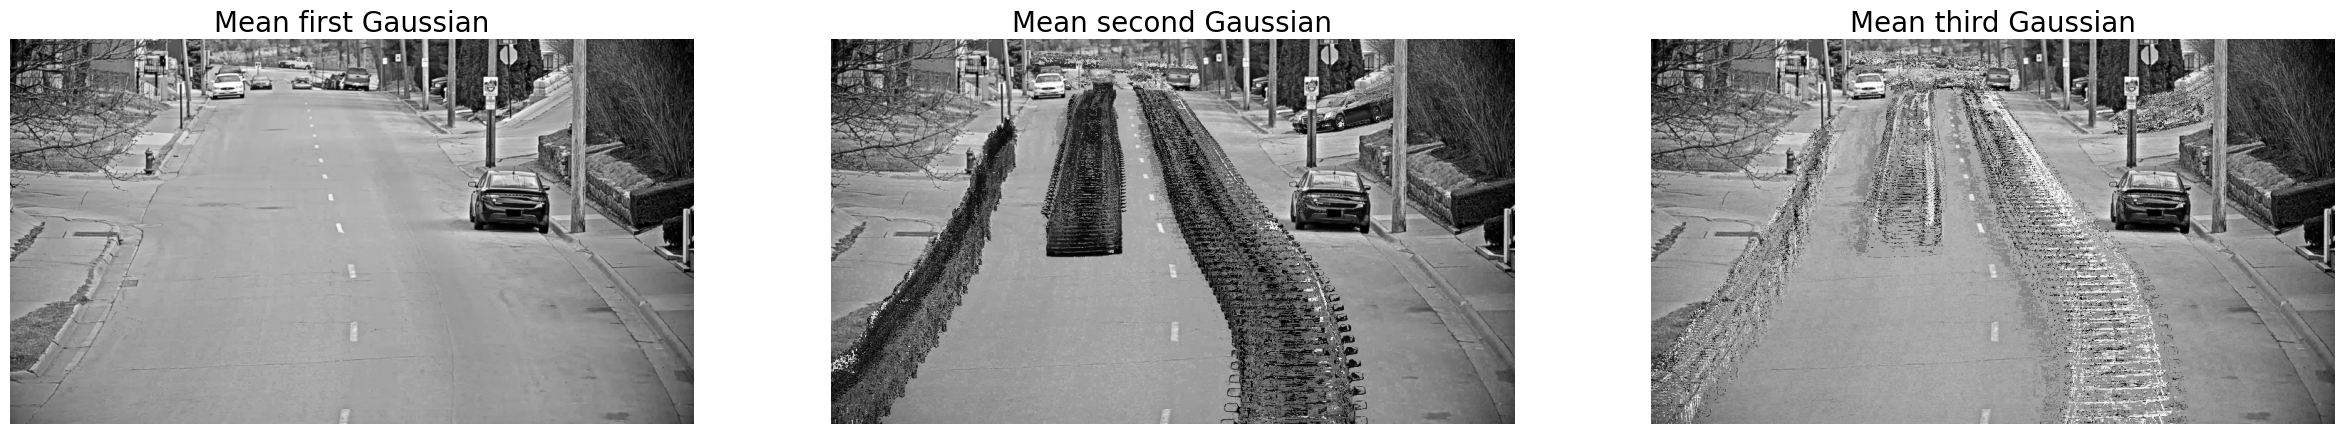

In [12]:
fig, ax = plt.subplots(1, 3, figsize=(30, 15))
ax[0].imshow(means[:,:,0], cmap='gray')
ax[0].set_title('Mean first Gaussian', fontsize=20)
ax[1].imshow(means[:,:,1], cmap='gray')
ax[1].set_title('Mean second Gaussian', fontsize=20)
ax[2].imshow(means[:,:,2], cmap='gray')
ax[2].set_title('Mean third Gaussian', fontsize=20)
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
plt.show()

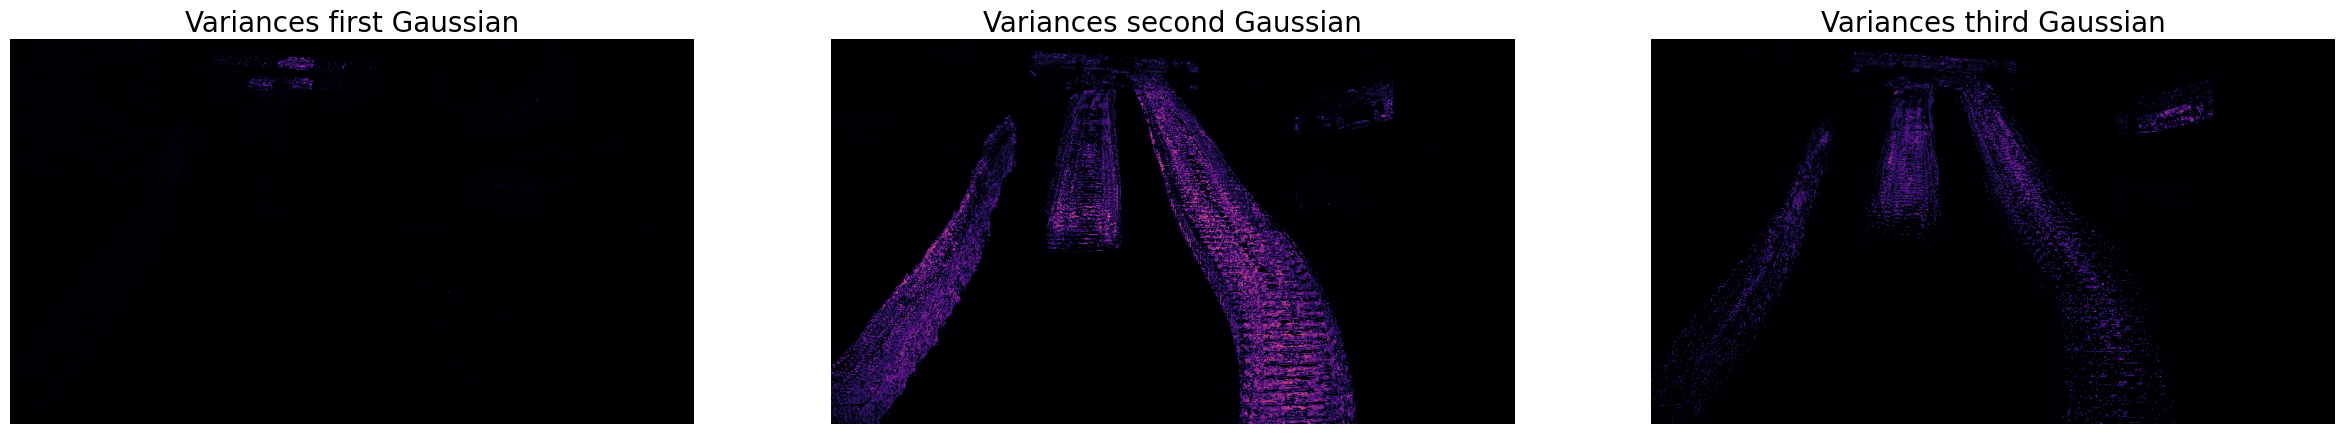

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(30, 15))
ax[0].imshow(variances[:,:,0], cmap='magma')
ax[0].set_title('Variances first Gaussian', fontsize=20)
ax[1].imshow(variances[:,:,1], cmap='magma')
ax[1].set_title('Variances second Gaussian', fontsize=20)
ax[2].imshow(variances[:,:,2], cmap='magma')
ax[2].set_title('Variances third Gaussian', fontsize=20)
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
plt.show()

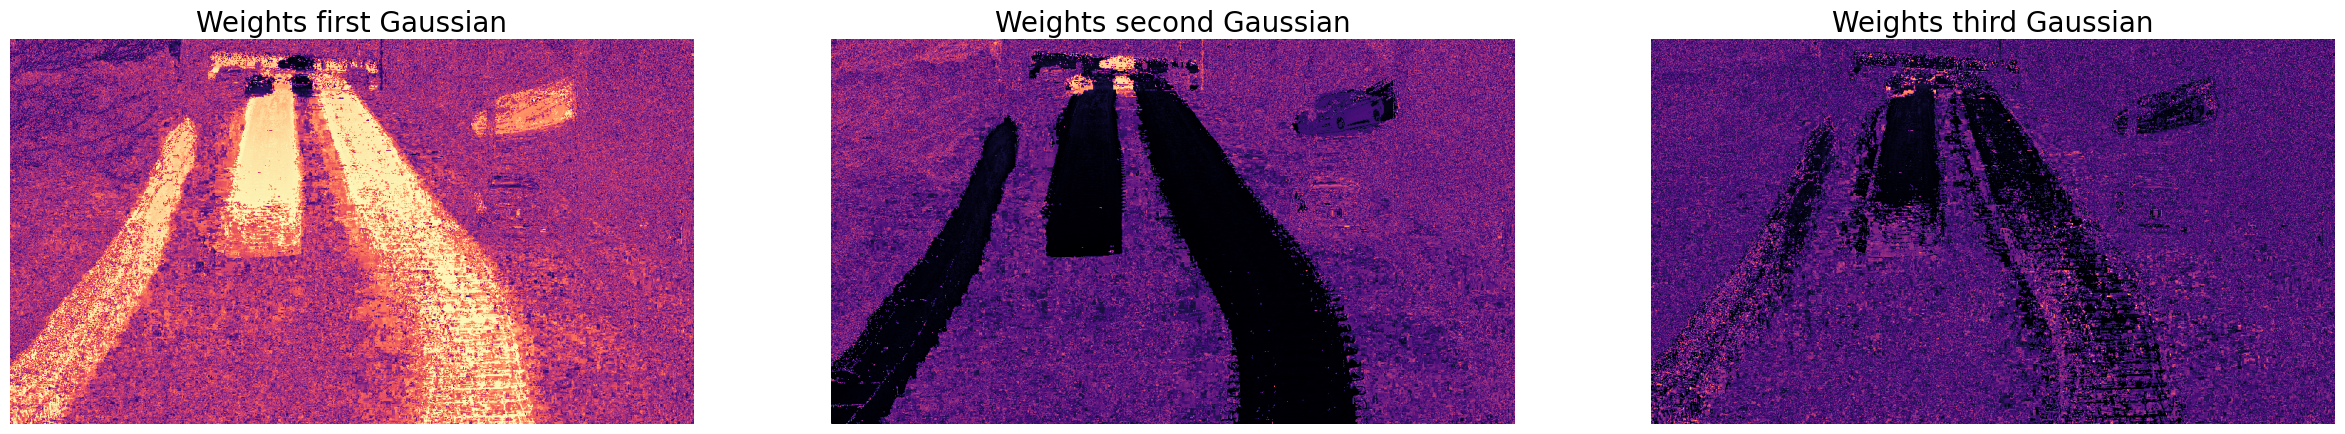

In [17]:
fig, ax = plt.subplots(1, 3, figsize=(30, 15))
ax[0].imshow(weights[:,:,0], cmap='magma')
ax[0].set_title('Weights first Gaussian', fontsize=20)
ax[1].imshow(weights[:,:,1], cmap='magma')
ax[1].set_title('Weights second Gaussian', fontsize=20)
ax[2].imshow(weights[:,:,2], cmap='magma')
ax[2].set_title('Weights third Gaussian', fontsize=20)
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
plt.show()